## EJERCICIO 1: MODELO DE SIMULACIÓN. OBTENCIÓN DE DATOS

#### CARGA DE BIBLIOTECAS

In [1]:
import sqlite3     
import matplotlib.pyplot as plt
import fitter as ft
import simpy as sim
import numpy as np
import datetime as dt
import pandas as pd
from scipy.stats import f
from math import ceil

## **DATOS**

In [2]:
worked_minutes = 8*60               # cantidad de minutos efectivamente trabajados por día

# CONECCIÓN A LA BASE DE DATOS

conexion=sqlite3.connect("/Users/lucianosmith/Documents/Investigación Operativa 3/1C2025/demos/C07/T_C07-1C2025_integrador.db")

### **PLAN DE PRODUCCIÓN**

In [3]:
# obtengo la fecha de inicio de la planificacion y final de planificación

m = conexion.execute(f"select min(sch_startdate) from schedule;")

start_date = dt.datetime.strptime(m.fetchall()[0][0], '%Y-%m-%d %H:%M:%S')  # convierto el string en tipo de dato fecha

m = conexion.execute(f"select max(sch_enddate) from schedule;")

end_date = dt.datetime.strptime(m.fetchall()[0][0], '%Y-%m-%d %H:%M:%S')    # convierto el string en tipo de dato fecha

start_date, end_date

(datetime.datetime(2024, 10, 1, 0, 0), datetime.datetime(2024, 10, 26, 10, 0))

### SECUENCIAS

In [4]:
# SECUENCIA INICIAL  formato: {(lote, producto, cantidad, siguiente_wc, color)}
# OBJETIVO: Necesito contar con información sobre la secuencia que cargo en las maquinas que dan inivio a la producción ...
# luego el sistema depende de cuando estas operaciones terminen para continuar. En otras palabras: "es el pool de inicio"

start_seq = {}  # secuencia inicial
seq = {}        # secuencia completa

m = conexion.execute(f"select sch_task, sch_lot, sch_product, sal_qty, "+
                     "(select p.prs_workcenter from process p where p.prs_product = sch_product and p.prs_prev=x.prs_code), "+
                     "sch_color from schedule, process x, sales where sal_so=sch_lot and x.prs_workcenter=sch_task and "+
                     "x.prs_product=sch_product and x.prs_prev=-1 order by sch_startdate asc;")

for i in m.fetchall():
    if i[0] in start_seq: 
        start_seq[i[0]].append((i[1], i[2], i[3], i[4], i[5])) # si existe el worck center hace un append
        seq[i[0]].append((i[1], i[2], i[3], i[4], i[5]))
    else:
        start_seq.update({i[0]: [(i[1], i[2], i[3], i[4], i[5])]})
        seq.update({i[0]: [(i[1], i[2], i[3], i[4], i[5])]})

start_seq

{'corte_m': [('SO#4001', 'VEZMU1EQ', 34, 'doblado', 'rojo'),
  ('SO#4002', 'QTROUV79', 23, 'doblado', 'blanco')],
 'corte_w': [('SO#4003', 'YUIIIP4W', 10, 'pintura', 'laca')]}

In [5]:
# SECUENCIA COMPLETA  formato: {(lote, producto, cantidad, siguiente_wc, color)}
# OBJETIVO: Necesito la secuencia completa de todas las operaciones. Recordar que el plan me informa la secuencia e información del
# momento de comienzo de las operaciones de iniciales. Luego, el progreso depende de, en este caso, factores estocásticos.

m = conexion.execute(f"select sch_task, sch_lot, sch_product, sal_qty, (select p.prs_workcenter from process p where p.prs_product = sch_product and p.prs_prev=x.prs_code), sch_color from schedule, process x, sales where sal_so=sch_lot and x.prs_workcenter=sch_task and x.prs_product=sch_product and x.prs_prev>-1 order by sch_startdate asc;")

for i in m.fetchall():
    if i[0] in seq: 
        seq[i[0]].append((i[1], i[2], i[3], i[4], i[5])) 
    else:
        seq.update({i[0]: [(i[1], i[2], i[3], i[4], i[5])]})

seq

{'corte_m': [('SO#4001', 'VEZMU1EQ', 34, 'doblado', 'rojo'),
  ('SO#4002', 'QTROUV79', 23, 'doblado', 'blanco')],
 'corte_w': [('SO#4003', 'YUIIIP4W', 10, 'pintura', 'laca'),
  ('SO#4002', 'QTROUV79', 23, 'tapizado', 'blanco')],
 'pintura': [('SO#4003', 'YUIIIP4W', 10, 'despacho', 'laca'),
  ('SO#4001', 'VEZMU1EQ', 34, 'despacho', 'rojo'),
  ('SO#4002', 'QTROUV79', 23, 'despacho', 'blanco')],
 'despacho': [('SO#4003', 'YUIIIP4W', 10, None, 'laca'),
  ('SO#4001', 'VEZMU1EQ', 34, None, 'rojo'),
  ('SO#4002', 'QTROUV79', 23, None, 'blanco')],
 'doblado': [('SO#4002', 'QTROUV79', 23, 'soldado', 'blanco'),
  ('SO#4001', 'VEZMU1EQ', 34, 'soldado', 'rojo')],
 'soldado': [('SO#4002', 'QTROUV79', 23, 'corte_w', 'blanco'),
  ('SO#4001', 'VEZMU1EQ', 34, 'pintura', 'rojo')],
 'tapizado': [('SO#4002', 'QTROUV79', 23, 'pintura', 'blanco')]}

### **DATOS DE LOS PROCESOS**


In [6]:
# EMPLEADOS POR CENTRO DE TRABAJO
# Obtengo un diccionario con la cantidad de empleados que cuento en cada centro de trabajo.

wc = {}
wcq = conexion.execute(f"select woc_code, woc_employees from work_center;")
for i in wcq:
    wc.update({i[0]: i[1]})

wc

{'corte_m': 2,
 'doblado': 1,
 'soldado': 2,
 'corte_w': 2,
 'tapizado': 1,
 'pintura': 1,
 'despacho': 3}

In [7]:
# TIEMPO DE PROCESO  formato {(producto, work center): (distribución, media/min, desvio/max)}
# La variabilidad de los tiempos se registró en la BD en forma de distribuciones. Busco dicha infomración.
# distribucion 1 = normal
# distribucion 2 = uniforme

m = conexion.execute(f"select prs_product, prs_workcenter, prs_time, prs_deviation, prs_distribution from process;")

t_process = {}

for i in m.fetchall(): 
        t_process.update({(i[0], i[1]): (i[4], i[2], i[3])})

t_process

{('VEZMU1EQ', 'corte_m'): (2, 48, 60),
 ('VEZMU1EQ', 'doblado'): (1, 38, 9.4),
 ('VEZMU1EQ', 'soldado'): (2, 56, 71),
 ('VEZMU1EQ', 'pintura'): (1, 36, 8.4),
 ('VEZMU1EQ', 'despacho'): (2, 20, 30),
 ('QTROUV79', 'corte_m'): (2, 45, 60),
 ('QTROUV79', 'doblado'): (1, 23, 8.7),
 ('QTROUV79', 'soldado'): (2, 32, 38),
 ('QTROUV79', 'corte_w'): (1, 34, 8.5),
 ('QTROUV79', 'tapizado'): (1, 102, 20.8),
 ('QTROUV79', 'pintura'): (1, 36, 9.8),
 ('QTROUV79', 'despacho'): (2, 34, 45),
 ('YUIIIP4W', 'corte_w'): (1, 23, 5.4),
 ('YUIIIP4W', 'pintura'): (1, 15, 2.4),
 ('YUIIIP4W', 'despacho'): (2, 24, 34)}

In [8]:
# CONSUMO DE MATERIA PRIMA  formato {(producto, proceso): cantidad}
# genero un diccionario con indices (producto, proceso) para obtener la cantidad de MP que se consume en cada operación 
# (y que varia por producto).

m = conexion.execute(f"select prs_product, prs_workcenter, prs_rawqty from process;")

t_rawqty = {}

for i in m.fetchall(): 
        t_rawqty.update({(i[0], i[1]): i[2]})

t_rawqty


{('VEZMU1EQ', 'corte_m'): 4.8,
 ('VEZMU1EQ', 'doblado'): 0,
 ('VEZMU1EQ', 'soldado'): 0,
 ('VEZMU1EQ', 'pintura'): 0.9,
 ('VEZMU1EQ', 'despacho'): 0,
 ('QTROUV79', 'corte_m'): 4.5,
 ('QTROUV79', 'doblado'): 0,
 ('QTROUV79', 'soldado'): 0,
 ('QTROUV79', 'corte_w'): 1.8,
 ('QTROUV79', 'tapizado'): 0,
 ('QTROUV79', 'pintura'): 0.3,
 ('QTROUV79', 'despacho'): 0,
 ('YUIIIP4W', 'corte_w'): 7.8,
 ('YUIIIP4W', 'pintura'): 0.8,
 ('YUIIIP4W', 'despacho'): 0}

In [9]:
# MATRIZ DE TIEMPOS DE CAMBIO DE COLOR  formato {(color1, color2) : tiempo} 
# obtengo la matriz de cambio (de color) de la base de datos y así genero un diccionario (de color, a color) 
# que me devuelve el tiempo para pasar de un color a otro.

m = conexion.execute(f"select c1.col_desc, c2.col_desc, cot_time from color_table, colors c1, colors c2 where c1.col_code = cot_orig and c2.col_code = cot_dest;")

setup_color_matrix = {}

for i in m.fetchall(): 
        setup_color_matrix.update({(i[0], i[1]): (i[2])})     

setup_color_matrix

{('laca', 'laca'): 25,
 ('laca', 'blanco'): 25,
 ('laca', 'crema'): 25,
 ('laca', 'marrón'): 25,
 ('laca', 'dorado'): 25,
 ('laca', 'rojo'): 25,
 ('laca', 'aluminio'): 25,
 ('laca', 'negro'): 25,
 ('blanco', 'laca'): 50,
 ('blanco', 'blanco'): 25,
 ('blanco', 'crema'): 30,
 ('blanco', 'marrón'): 30,
 ('blanco', 'dorado'): 30,
 ('blanco', 'rojo'): 30,
 ('blanco', 'aluminio'): 30,
 ('blanco', 'negro'): 30,
 ('crema', 'laca'): 50,
 ('crema', 'blanco'): 40,
 ('crema', 'crema'): 25,
 ('crema', 'marrón'): 30,
 ('crema', 'dorado'): 30,
 ('crema', 'rojo'): 30,
 ('crema', 'aluminio'): 30,
 ('crema', 'negro'): 30,
 ('marrón', 'laca'): 50,
 ('marrón', 'blanco'): 50,
 ('marrón', 'crema'): 50,
 ('marrón', 'marrón'): 25,
 ('marrón', 'dorado'): 30,
 ('marrón', 'rojo'): 50,
 ('marrón', 'aluminio'): 50,
 ('marrón', 'negro'): 30,
 ('dorado', 'laca'): 50,
 ('dorado', 'blanco'): 50,
 ('dorado', 'crema'): 50,
 ('dorado', 'marrón'): 30,
 ('dorado', 'dorado'): 25,
 ('dorado', 'rojo'): 50,
 ('dorado', 'alumin

In [10]:
# CALCULO DE AUSENTISMO (work center: CORTE)
# El centro de trabajo de CORTE tiene ausentismo. Hay cierta probabilidad de que un operario falte.
# debo calcular cual es la probabilidad en base al historico de ausentismo.

a = conexion.execute(f"select count(*) from attendance where att_attendance = 1 and att_workcenter = 'CORTE';")
b = conexion.execute(f"select count(*) from attendance where att_workcenter = 'CORTE';")
p_ausentismo = 1-(a.fetchall()[0][0]/b.fetchall()[0][0])

print(p_ausentismo)

0.15349740932642486


In [11]:
# FERIADOS formato (dia, mes, año)
# Obtengo los días feriados.

s = conexion.execute(f"select * from feriados;")
holidays = []
for i in s.fetchall():
    holidays.append( (i[0],i[1],i[2]) )

holidays

[(25, 10, 2024), (3, 10, 2024)]

### **INFORMACION DE ALMACENAMIENTO**

In [12]:
# STOCK DE MATERIA PRIMA {codigo: cantidad inicial}
# obtengo información de stock de MP.

s = conexion.execute(f"select * from stock;")
stk = {}
for i in s.fetchall():
    stk.update({i[1]: i[3]})

stk

{'madera': 1500,
 'metal': 7000,
 'laca': 70,
 'blanco': 100,
 'crema': 80,
 'marron': 55,
 'dorado': 12,
 'rojo': 500,
 'aluminio': 42,
 'negro': 10}

In [13]:
# REAPROVISIONAMIENTO  formato [(minutos (dif), codigo materia prima, cantidad que ingresa)]
# Obtengo las fechas y cantidades de MP que se va a reponer. La fecha la calculo en funcion de los minutos que pasan
# desde el inicio de la produccion hasta la fecha de reaprovisionamiento.

def get_min(fecha):
    diff = fecha - start_date
    min = 0
    day = start_date
    for d in range(diff.days):        
        if (day.weekday()<5) and ((day.day, day.month, day.year) not in holidays): 
            min += worked_minutes
        day = day + dt.timedelta(days=1)
    return min

reaprovisionamiento = []

s = conexion.execute(f"select * from to_receive where tre_status='waiting' order by tre_date asc;")

t0 = 0
for i in s.fetchall():
    tt = get_min(dt.datetime.strptime(i[4], '%Y-%m-%d'))
    reaprovisionamiento.append((tt-t0, i[2], i[3]))
    t0 = tt

reaprovisionamiento

[(480, 'metal', 600),
 (480, 'madera', 300),
 (0, 'metal', 400),
 (0, 'laca', 30),
 (480, 'laca', 45),
 (0, 'blanco', 80),
 (0, 'crema', 30),
 (0, 'aluminio', 80),
 (1440, 'negro', 10),
 (960, 'marron', 12),
 (480, 'dorado', 30),
 (0, 'rojo', 250),
 (960, 'rojo', 300),
 (960, 'marron', 10),
 (480, 'aluminio', 80)]

### **MANTENIMIENTO**

### AJUSTE DE TIEMPOS DE MANTENIMIENTO

{'norm': (138.992, 15.06412745564774)}


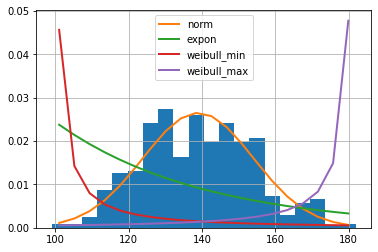

In [14]:
# DOBLADORA (TTR)
# En base a información historica de mantenimiento se obtiene la distribución del TTR de la dobladora.

m = conexion.execute(f"select mai_ttr from maintenance where mai_machine='DOBLADORA' and mai_type='C';")
d_ttr = [i[0] for i in m.fetchall()] 

# ajuste y obtención de parámetros

f2 = ft.Fitter(d_ttr, bins=20, timeout=100, distributions=['norm', 'expon', 'weibull_max','weibull_min'])
f2.fit()
f2.summary()

u_ttr = f2.get_best()['norm'][0]
d_ttr = f2.get_best()['norm'][1]

print(f2.get_best())

{'f': (3.447816595522619, 13.8683456034166, -14.313661056778123, 5977.9059421798975)}


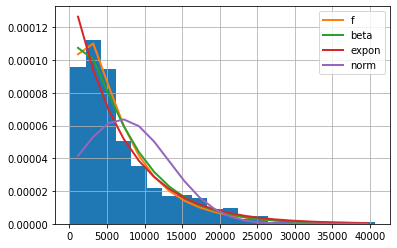

In [15]:
# DOBLADORA (TBF)
# En base a información historica de mantenimiento se obtiene la distribución del TBF de la dobladora.

m = conexion.execute(f"select mai_tbf from maintenance where mai_machine='DOBLADORA' and mai_type='C';")
d_tbf = [i[0] for i in m.fetchall()] 

# ajuste y obtención de parámetros
f1 = ft.Fitter(d_tbf, bins=20, timeout=100, distributions=['norm', 'expon','beta', 'f'])
f1.fit()
f1.summary()

a_tbf = f1.get_best()['f'][0]
b_tbf = f1.get_best()['f'][1]
c_tbf = f1.get_best()['f'][2]
d_tbf = f1.get_best()['f'][3]

print(f1.get_best())

In [16]:
conexion.close()